In [1]:
import numpy as np
import pandas as pd 
import scanpy as sc
import utils
import mrf
import os 
import imp

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_13987/4233533901.py:7: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [63]:
imp.reload(mrf)

<module 'mrf' from '/home/qinxianhan/project/spatial/Hidden_Markov_Random_Field/src/mrf.py'>

In [2]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(8,8))
import seaborn as sns

In [3]:
adata = sc.read_visium('../../dataset/goldStandard')
adata.var_names_make_unique()
adata = utils.data_preprocess(adata)

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
from sklearn import mixture 
gmm = mixture.GaussianMixture(n_components=2)

In [5]:
coord = np.array(adata.obs.iloc[:,1:3])
target_list =['CAMK2N1', 'PCP4', 'NEFM', 'NEFH', 'B3GALT2']
target_gene =target_list[1]

In [64]:
beta =5
labels_list= mrf.mrf_process(adata, gene_id=target_gene, beta = beta,max_iteration=5e4)

[(-1, 1), (1, 1), (1, -1), (1, 1), (0, 2), (0, -2)]
77 121


 16%|█▌        | 8108/50000 [00:00<00:01, 21329.11it/s]100%|██████████| 50000/50000 [00:01<00:00, 26671.60it/s]

2447 pixels changed after 50000 iterations
[[-0.09712451  0.20405536]
 [ 0.40572768  0.96287224]]


In [85]:
beta = 3
labels_list_new,cluster_prob= mrf.mrf_with_icmem(adata, gene_id = target_gene, beta = beta, max_iter = 10)

100%|██████████| 10/10 [00:03<00:00,  2.59it/s]

[[ 9.53788610e-01  3.54916776e-01]
 [-8.70590508e-01  1.00000000e-05]]


In [35]:
exp = adata[:,target_gene].X.toarray()
gmm = mixture.GaussianMixture(n_components=2)
gmm.fit(exp)
gmm_labels = gmm.predict(exp)

In [36]:
gmm.means_.reshape(-1), gmm.covariances_.reshape(-1)

(array([ 0.95385807, -0.87059051]), array([3.54804567e-01, 1.00000000e-06]))

In [37]:
def label_reverse(labels_list):
    labels_list = 1-labels_list 
    return labels_list

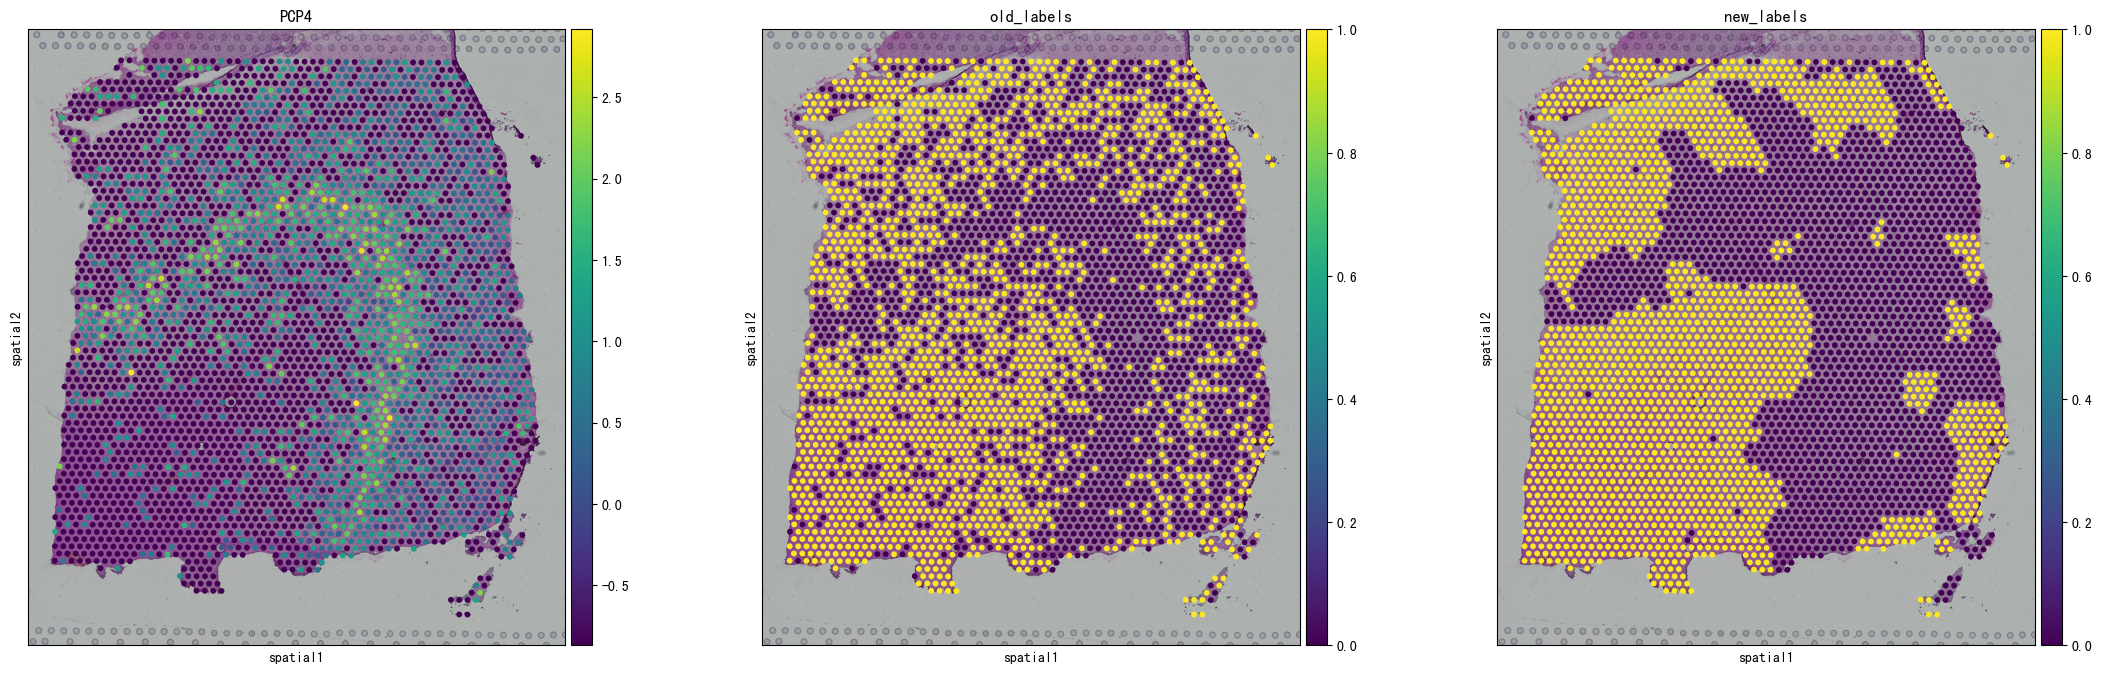

In [84]:
adata.obs['old_labels'] = gmm_labels
adata.obs['new_labels'] = labels_list
sc.pl.spatial(adata, color=[target_gene,'old_labels','new_labels'])

In [79]:
labels_list = label_reverse(labels_list)